In [1]:
import math
import os

import matplotlib.dates as mdates
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import MSTL, STL

from msig import Motif, NullModel

params = {"legend.fontsize": "xx-large", "axes.labelsize": 20}
pylab.rcParams.update(params)

In [2]:
# query = "SELECT * FROM mob_data_aggregated_hourly_taz_withgeom_view;"
# gdf_data = gpd.read_postgis(
#   query, engine, geom_col="wkt_taz", crs="EPSG:4326")
# gdf_data.to_csv('../data/populationdensity/hourly_taz.csv')
# gdf_data.head()

In [3]:
# read csv
data = pd.read_csv(
    "../data/populationdensity/hourly_taz.csv",
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
)
# taz_id to taz_name dict
taz_id_name = {}
for taz_id in data["taz_id"].unique():
    taz_name = data[data["taz_id"] == taz_id]["taz_name"].values[0]
    taz_id_name[taz_id] = taz_name

data = data[data["taz_name"] != "Beato (Picheleira)"]
data = data[data["taz_name"] != "Alcântara (Ribeirinha - Belém)"]
data

Unnamed: 0  taz_id                                taz_name  \
0                0      69                     Areeiro (Alto Pina)   
1                1      70                     Arroios (Estefânia)   
2                2      71               Arroios (Arroios | Norte)   
3                3      53                 Alvalade (Campo Grande)   
4                4      40              Lumiar (Telheiras | Oeste)   
...            ...     ...                                     ...   
175218      175218      16                       Estrela (Estrela)   
175219      175219      12                   Ajuda (Ajuda | Norte)   
175220      175220      15                          Estrela (Lapa)   
175221      175221      13            Estrela (Ribeirinha - Belém)   
175222      175222      66  Avenidas Novas (Avenidas Novas | Este)   

                  one_time  sum_terminals  sum_roaming_terminals  \
0      2021-11-26 09:00:00        61599.0                 1131.0   
1      2021-11-26 09:00:00       145078.0                 4477.0   
2      2021-11-26 09:00:00        31194.0                  945.0   
3      2021-11-26 09:00:00        51055.0                  864.0   
4      2021-11-26 09:00:00        40523.0                  255.0   
...                    ...            ...                    ...   
175218 2021-11-26 09:00:00       199615.0                 6739.0   
175219 2021-11-26 09:00:00        27901.0                  487.0   
175220 2021-11-26 09:00:00         9932.0                  432.0   
175221 2021-11-26 09:00:00         6586.0                  138.0   
175222 2021-11-26 09:00:00       150273.0                 2975.0   

        sum_terminals_with_active_data  \
0                              58113.0   
1                             138532.0   
2                              29608.0   
3                              48474.0   
4                              37014.0   
...                                ...   
175218                        190222.0   
175219                         25890.0   
175220                          9298.0   
175221                          6119.0   
175222                        142580.0   

        sum_roaming_terminals_with_active_data  sum_phonecalls  \
0                                       1107.0          2896.0   
1                                       4351.0          5149.0   
2                                        920.0          1284.0   
3                                        849.0          1520.0   
4                                        252.0          2314.0   
...                                        ...             ...   
175218                                  6497.0          7990.0   
175219                                   481.0          1100.0   
175220                                   429.0           605.0   
175221                                   138.0           410.0   
175222                                  2910.0          6224.0   

        sum_ended_phonecalls  avg_upstream_bandwidth  \
0                      574.0             7524.772105   
1                     1178.0             7678.938176   
2                      420.0             5017.655536   
3                      474.0             8951.088582   
4                      382.0             3442.786203   
...                      ...                     ...   
175218                1839.0            10347.174511   
175219                 342.0           199281.838168   
175220                 154.0             3801.634144   
175221                  77.0             2781.907062   
175222                1741.0             9989.279638   

        avg_downstream_bandwidth  min_avg_downstream_bandwidth  \
0                  101178.976512                    104.328000   
1                   53412.218959                   2752.320035   
2                   58454.086946                    943.014966   
3                   70079.739010                   2236.359946   
4                   32570.243025                 

In [4]:
results_path = "../results/populationdensity/hourly_taz"
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")
    os.makedirs(results_path + "/mp_indices")

In [5]:
features = ["sum_terminals"]
stats_table = pd.DataFrame()
resids = {}
# for each taz_id
for taz_id in data["taz_id"].unique():
    # get the data for that taz_id
    taz_data = data[data["taz_id"] == taz_id]
    taz_data = taz_data.drop(columns=["taz_name"])
    taz_data["datetime"] = pd.to_datetime(taz_data["one_time"])
    taz_data = taz_data.drop(columns=["one_time", "taz_id", "wkt_taz"])
    taz_data.set_index("datetime", inplace=True)
    for data_feature in features:
        time_serie = taz_data[[data_feature]].asfreq("h")
        if np.all(time_serie == 0):
            continue
        res = MSTL(np.squeeze(time_serie), periods=[24, 24 * 7]).fit()
        resids[str(taz_id) + "_" + data_feature] = res.resid

        var_resid = np.var(res.resid)
        var_observed = np.var(res.observed)
        trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
        noise_strength = var_resid / var_observed

        seasonal_individial_strengths = {}
        for period in res.seasonal:
            seasonal_individial_strengths["F_" + str(period)] = max(
                0, 1 - (var_resid / np.var(res.seasonal[period] + res.resid))
            )
        seasonal_strength = max(
            0, 1 - (var_resid / np.var(res.seasonal.sum(axis=1) + res.resid))
        )

        stats_df = {
            "id": taz_id,
            "Feature": data_feature,
            "F_T": round(trend_strength, 3),
            "F_S": round(seasonal_strength, 3),
            "F_R": round(noise_strength, 3),
        }

        # add individual seasonal strengths to stats_df, rounded with 3 decimals
        for period in seasonal_individial_strengths:
            stats_df[period] = round(seasonal_individial_strengths[period], 3)

        stats_table = pd.concat(
            [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
        )

stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
# save the table
stats_table.to_csv(results_path + "/hourly_taz_decomposition_summary.csv", index=False)
# get the name from the taz id
stats_table["Name"] = stats_table["id"].apply(lambda x: taz_id_name[x])
stats_table

id        Feature    F_T    F_S    F_R  F_seasonal_24  F_seasonal_168  \
5    37  sum_terminals  0.059  0.404  0.574          0.267           0.236   
7    41  sum_terminals  0.057  0.554  0.434          0.414           0.351   
64   77  sum_terminals  0.352  0.445  0.425          0.319           0.252   
57   72  sum_terminals  0.293  0.510  0.406          0.378           0.305   
36   83  sum_terminals  0.366  0.470  0.403          0.328           0.282   
..  ...            ...    ...    ...    ...            ...             ...   
82  100  sum_terminals  0.371  0.878  0.113          0.845           0.632   
63   74  sum_terminals  0.672  0.862  0.108          0.837           0.522   
96   89  sum_terminals  0.158  0.893  0.105          0.885           0.447   
67   29  sum_terminals  0.863  0.732  0.102          0.649           0.458   
70   30  sum_terminals  0.922  0.623  0.070          0.519           0.351   

                                             Name  
5   São Domingos de Benfica (Estrada Luz | Oeste)  
7                       Lumiar (Telheiras | Este)  
64                 Penha de França (Penha França)  
57                        Arroios (Arroios | Sul)  
36                               Marvila (Chelas)  
..                                            ...  
82            Parque das Nações (Estação Oriente)  
63                      Santa Maria Maior (Baixa)  
96                             Lumiar (Aeroporto)  
67    São Domingos de Benfica (Sete Rios | Norte)  
70   São Domingos de Benfica (Estrada Luz | Este)  

[101 rows x 8 columns]

In [6]:
# to latex first 5 rows with name, trend, seasonals and noise
print(
    stats_table[["Name", "F_T", "F_seasonal_24", "F_seasonal_168", "F_R"]]
    .head(5)
    .to_latex()
)

\begin{tabular}{llrrrr}
\toprule
 & Name & F_T & F_seasonal_24 & F_seasonal_168 & F_R \\
\midrule
5 & São Domingos de Benfica (Estrada Luz | Oeste) & 0.059000 & 0.267000 & 0.236000 & 0.574000 \\
7 & Lumiar (Telheiras | Este) & 0.057000 & 0.414000 & 0.351000 & 0.434000 \\
64 & Penha de França (Penha França) & 0.352000 & 0.319000 & 0.252000 & 0.425000 \\
57 & Arroios (Arroios | Sul) & 0.293000 & 0.378000 & 0.305000 & 0.406000 \\
36 & Marvila (Chelas) & 0.366000 & 0.328000 & 0.282000 & 0.403000 \\
\bottomrule
\end{tabular}



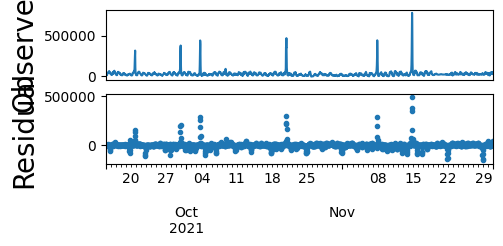

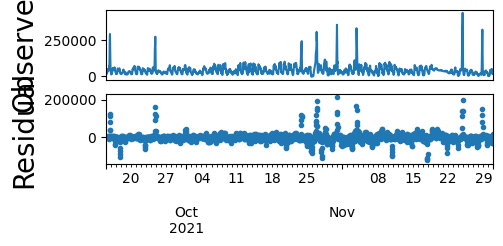

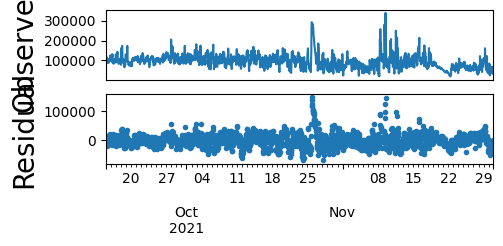

In [7]:
# plot the data and residuals of top 3 taz_ids
top_taz_ids = stats_table["id"].head(3).values
# create dataframe with taz_id and resids
top_resids = pd.DataFrame()
for taz_id in top_taz_ids:
    for data_feature in features:
        # add to dataframe, id, data feature and daoly
        observed = (
            data[data["taz_id"] == taz_id][[data_feature, "one_time"]]
            .sort_values(by="one_time")
            .set_index("one_time")
        )
        index = observed.index.values
        row = {
            "id": taz_id,
            "feature": data_feature,
            "index": index,
            "observed": observed.T.values[0],
            "residuals": resids[str(taz_id) + "_" + data_feature],
        }
        top_resids = pd.concat([top_resids, pd.DataFrame(row)], ignore_index=True)


# for (id, feature) get dataframe and plot observed and residuals
for i, df in top_resids.groupby(by=["id", "feature"]):
    # plot observed and residuals
    fig, axes = plt.subplots(figsize=(5, 2), ncols=1, nrows=2, sharex=True)
    observed = pd.DataFrame(df["observed"].values, index=df["index"])
    resid = pd.DataFrame(df["residuals"].values, index=df["index"])
    observed.plot(ax=axes[0], legend=False, label="", xlabel="", ylabel="Observed")
    resid.plot(ax=axes[1], style=".", legend=False, xlabel="", ylabel="Residual")
    axes[0].axes.get_xaxis().set_visible(False)
    plt.show()

In [8]:
# motif discovery
import stumpy

# discover motifs
normalize = True
subsequence_lengths = [6, 12, 24]

In [9]:
for m in subsequence_lengths:
    for i, df in top_resids.groupby(by=["id", "feature"]):
        X = np.squeeze(df["residuals"].values)
        out = stumpy.stump(X, m, normalize=normalize)
        np.save(
            results_path
            + "/mp/hourly_taz_normalized={}_m={}_{}_{}.npy".format(
                normalize, m, i[0], i[1]
            ),
            out,
            allow_pickle=True,
        )

In [10]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))


def table_summary_motifs(
    motif_indices,
    motif_distances,
    motif_subspaces,
    data,
    m,
    normalize,
    max_allowed_dist,
):
    mp_stats_table = pd.DataFrame(
        columns=[
            "ID",
            "k",
            "Features",
            "m",
            "#Matches",
            "Indices",
            "max(dists)",
            "min(dists)",
            "med(dists)",
        ]
    )

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[
            :, np.newaxis
        ]

    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):
        dimensions = motif_subspaces[motif_indice]

        # remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        # if is empty, skip
        if len(match_indices) == 0:
            continue

        # remove trivial matches
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) <= m / 2:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time - m) / np.ceil(m / 2) + 1))

        # get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][
            :, match_indices[0] : match_indices[0] + m
        ]

        # minmax normalize subsequence
        epsilon = 1e-10  # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (
            max_values - min_values + epsilon
        )
        ce_norm_subsequence = multivar_subsequence_complexity(
            normalized_multivar_subsequence
        )
        norm_ce_norm_subsequence = ce_norm_subsequence / (
            np.sqrt(len(multivar_subsequence[0]) - 1) * len(dimensions)
        )

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])

        # D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time - m + 1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:, i] = stumpy.mass(
                    multivar_subsequence[i], data[dimension], normalize=normalize
                )
            D = np.mean(D, axis=0)
            max_allowed_dist = max(
                np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)]), epsilon
            )

        unified_weights = "0.33,0.33,0.33"
        excl_zone = np.ceil(m / 4)
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = (
            w1 * (1 - (med_dist / max_allowed_dist))
            + w2 * (len(match_indices) / max_possible_matches)
            + w3 * norm_ce_norm_subsequence
        )

        # remove timepoints from time series in match all indices + m
        time_series_nomatches = data.copy()
        # list of indexes to remove
        indexes_to_remove = [
            i for index in match_indices for i in range(index, index + m)
        ]
        # put zero in the indexes to remove
        time_series_nomatches[:, indexes_to_remove] = 0

        # calculate variance explained by the motif
        vars_explained = []
        for i in range(len(dimensions)):
            vars_explained.append(
                100
                * (
                    1
                    - (
                        np.mean(np.abs(time_series_nomatches[i]))
                        / np.mean(np.abs(data[i]))
                    )
                )
            )

        variance_explained = np.mean(vars_explained)

        # data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # max_delta = max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2 / m)
        delta_thresholds = [max_delta] * len(data)

        #########SIG#########
        motif = Motif(
            multivar_subsequence, dimensions, delta_thresholds, len(match_indices)
        )
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(
            max_possible_matches, n_vars, idd_correction=False
        )

        stats_df = {
            "ID": str(motif_index),
            "k": len(dimensions),
            "Features": ",".join(used_features),
            "m": m,
            "#Matches": len(match_indices) - 1,
            "Indices": match_indices,
            "max(dists)": np.around(max_dist, 3),
            "min(dists)": np.around(min_dist, 3),
            "med(dists)": np.around(med_dist, 3),
            "CE": np.around(norm_ce_norm_subsequence, 3),
            "Score Unified": np.around(unified, 3),
            "Explained Var(%)": np.around(variance_explained, 2),
            "P": p,
            "p-value": pvalue,
        }

        mp_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if mp_stats_table.empty
            else pd.concat(
                [mp_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

        motif_index += 1
    return mp_stats_table

In [11]:
k = None
min_neighbors = 1
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
for i, df in top_resids.groupby(by=["id", "feature"]):
    print(i[0], taz_id_name[i[0]])
    mp_stats_table = pd.DataFrame()
    for m in subsequence_lengths:
        X = np.squeeze(df["residuals"].values)
        mp = np.load(
            results_path
            + "/mp/hourly_taz_normalized=True_m={}_{}_{}.npy".format(m, i[0], i[1]),
            allow_pickle=True,
        )
        motif_distances, motif_indices = stumpy.motifs(
            X,
            mp[:, 0],
            max_distance=max_distance,
            max_matches=max_matches,
            cutoff=cutoff,
            min_neighbors=min_neighbors,
            max_motifs=max_motifs,
            normalize=normalize,
        )
        if len(motif_indices[0]) == 0:
            continue
        print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
        # to work with table_summary_motifs which expects multidimensional motifs
        motif_subspaces = [np.array([0])] * len(motif_indices)
        X = np.array([X])
        table = table_summary_motifs(
            motif_indices,
            motif_distances,
            motif_subspaces,
            X,
            m,
            normalize,
            max_distance,
        )
        print("Sig ", np.sum(table["p-value"] < 0.001))
        # hochberg procedure
        p_values = table["p-value"].to_numpy()
        critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
        sig = (
            table["p-value"] < critical_value
            if critical_value != 0
            else table["p-value"] <= critical_value
        )
        table["Sig_Hochber"] = sig

        print(
            "Sig after Hochberg: {}, critical value: {}".format(
                np.sum(sig), critical_value
            )
        )
        mp_stats_table = (
            table
            if mp_stats_table.empty
            else pd.concat([mp_stats_table, table], ignore_index=True)
        )
    mp_stats_table.to_csv(
        results_path
        + "/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]
        ),
        index=False,
    )

37 São Domingos de Benfica (Estrada Luz | Oeste)
m:6, #Motifs:41
Sig  4
Sig after Hochberg: 3, critical value: 5.7995413668510585e-06
m:12, #Motifs:30
Sig  7
Sig after Hochberg: 6, critical value: 4.911338679126461e-59
m:24, #Motifs:18
Sig  8
Sig after Hochberg: 7, critical value: 1.1677323349884854e-31
41 Lumiar (Telheiras | Este)
m:6, #Motifs:36
Sig  3
Sig after Hochberg: 2, critical value: 1.0152487449609545e-20
m:12, #Motifs:29
Sig  9
Sig after Hochberg: 8, critical value: 0.0002669280446797651
m:24, #Motifs:20
Sig  9
Sig after Hochberg: 9, critical value: 0.0010711254728917419
77 Penha de França (Penha França)
m:6, #Motifs:28
Sig  7
Sig after Hochberg: 7, critical value: 0.008712729847905016
m:12, #Motifs:28
Sig  19
Sig after Hochberg: 22, critical value: 0.04081826288995497
m:24, #Motifs:23
Sig  23
Sig after Hochberg: 22, critical value: 2.803211303122293e-09


In [12]:
# create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std,
# average probability +- std, average pvalue +- std)

for i, df in top_resids.groupby(by=["id", "feature"]):
    print(i[0], taz_id_name[i[0]])
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]
        )
    )
    motif_lengths = mp_stats_table["m"].unique()
    motif_stats_table = pd.DataFrame(
        columns=[
            "m",
            "#motifs",
            "avg_n_matches",
            "avg_n_features",
            "avg_probability",
            "avg_pvalue",
            "#sig_motifs(<0.01)",
            "significant",
            "#sig_hochberg",
        ]
    )
    for m in motif_lengths:
        table = mp_stats_table[mp_stats_table["m"] == m]
        if table.empty:
            continue
        n_motifs = table.shape[0]
        n_sig_motifs_0001 = table[table["p-value"] < 0.001].shape[0]
        n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
        avg_n_matches = (
            round(table["#Matches"].mean(), 2),
            round(table["#Matches"].std(), 3),
        )
        avg_n_features = round(table["k"].mean(), 2), round(table["k"].std(), 3)
        avg_probability = table["P"].mean(), table["P"].std()
        avg_pvalue = table["p-value"].mean(), table["p-value"].std()

        stats_df = {
            "m": m,
            "#motifs": n_motifs,
            "#sig_motifs(<0.001)": n_sig_motifs_0001,
            "significant": (n_sig_motifs_0001 * 100) / n_motifs,
            "avg_n_matches": avg_n_matches,
            "avg_n_features": avg_n_features,
        }

        motif_stats_table = (
            pd.DataFrame.from_records([stats_df])
            if motif_stats_table.empty
            else pd.concat(
                [motif_stats_table, pd.DataFrame.from_records([stats_df])],
                ignore_index=True,
            )
        )

    print(motif_stats_table)

37 São Domingos de Benfica (Estrada Luz | Oeste)
    m  #motifs  #sig_motifs(<0.001)  significant    avg_n_matches  \
0   6       41                    4     9.756098  (39.56, 14.389)   
1  12       30                    7    23.333333   (37.5, 10.003)   
2  24       18                    8    44.444444   (30.39, 9.319)   

  avg_n_features  
0     (1.0, 0.0)  
1     (1.0, 0.0)  
2     (1.0, 0.0)  
41 Lumiar (Telheiras | Este)
    m  #motifs  #sig_motifs(<0.001)  significant    avg_n_matches  \
0   6       36                    3     8.333333  (41.53, 16.654)   
1  12       29                    9    31.034483   (39.69, 9.142)   
2  24       20                    9    45.000000   (27.85, 6.327)   

  avg_n_features  
0     (1.0, 0.0)  
1     (1.0, 0.0)  
2     (1.0, 0.0)  
77 Penha de França (Penha França)
    m  #motifs  #sig_motifs(<0.001)  significant   avg_n_matches  \
0   6       28                    7    25.000000  (59.82, 6.939)   
1  12       28                   19    67.8571

In [13]:
# read motifs table
for i, df in top_resids.groupby(by=["id", "feature"]):
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]
        ),
        index_col=0,
    )

    # for motif in mp_stats_table
    indexes_to_remove = set()
    for index, motif in mp_stats_table.iterrows():
        indexes_to_remove.update(
            [
                i
                for index in eval(motif["Indices"])
                for i in range(int(index), int(index) + int(motif["m"]))
            ]
        )

    resids = df["residuals"]
    resids.index = df["index"]
    resids = pd.DataFrame(resids).T
    datetime_indexes_to_remove = resids.T.index[sorted(indexes_to_remove)]

    residual_nomatches = resids.T.copy()
    for feature in residual_nomatches.columns:
        residual_nomatches.loc[datetime_indexes_to_remove, feature] = 0
        variance_explained = 100 * (
            1
            - (
                np.mean(np.abs(residual_nomatches[feature]))
                / np.mean(np.abs(resids.T[feature]))
            )
        )
        print(f"{feature}: {variance_explained}")

residuals: 100.0
residuals: 100.0
residuals: 100.0


In [14]:
# get top 3 most significant for each motif length
for i, df in top_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]
        )
    )
    # excluded p-value > 0.001
    mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    subsequence_lengths = mp_stats_table["m"].unique()
    for m in subsequence_lengths:
        print("########## m:{} #########".format(m))
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        top_motifs = top_motifs[
            [
                "ID",
                "#Matches",
                "CE",
                "Score Unified",
                "max(dists)",
                "min(dists)",
                "med(dists)",
                "p-value",
                "Explained Var(%)",
            ]
        ]
        top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
        print(top_motifs.to_latex(index=False, float_format="%.3f"))
        print("\n")

########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
########## m:6 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
4 & 33 & 0.300 & 0.395 & 0.827 & 0.092 & 0.520 & 2.64e-38 & 13.240 \\
3 & 39 & 0.324 & 0.389 & 0.974 & 0.078 & 0.685 & 2.35e-84 & 14.360 \\
7 & 31 & 0.265 & 0.379 & 0.696 & 0.109 & 0.549 & 5.80e-06 & 16.370 \\
6 & 43 & 0.312 & 0.369 & 0.979 & 0.106 & 0.869 & 3.43e-77 & 26.000 \\
\bottomrule
\end{tabular}



########## m:12 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
2 & 37 & 0.170 & 0.353 & 1.652 & 0.270 & 1.062 & 1.19e-73 & 34.620 \\
1 & 42 & 0.227 & 0.347 & 2.317 & 0.231 & 1.493 & 5.49e-95 & 43.100 \\
4 & 37 & 0.188 & 0.346 & 1.776 & 0.291 & 1.243 & 5.45e-78 & 36.650 \\
0 & 36 & 0.216 & 0.341 & 2.238 & 0.193 & 1.443 & 7.2

In [15]:
def plot_motif(ts_list, features, m, motif_indexes, motif_name, save_path):
    fig, axes = plt.subplots(
        ncols=3, nrows=len(ts_list), figsize=(10, 3 * len(ts_list)), squeeze=False
    )
    for i in range(0, len(ts_list)):
        ts = ts_list[i]
        # plot light grey
        axes[i, 2].plot(ts, color="black", linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i, 0].set_prop_cycle("color", colors)
        axes[i, 1].set_prop_cycle("color", colors)
        axes[i, 2].set_prop_cycle("color", colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index : index + m]
            normalized_subsequence_match = (
                subsequence_match - np.mean(subsequence_match)
            ) / np.std(subsequence_match)
            # original motif in the next plot with the same color
            axes[i, 1].plot(subsequence_match.values)
            # z-normalized motif in the next plot
            axes[i, 0].plot(normalized_subsequence_match.values)
            # highlight the motif in the original time serie
            axes[i, 2].plot(subsequence_match, linewidth=2)

        if m <= 12:
            axes[i, 0].set_xticks(range(0, len(subsequence_match)))
            axes[i, 0].set_xticklabels(
                [
                    "i+" + str(i) if i != 0 else "i"
                    for i in range(0, len(subsequence_match))
                ]
            )
            axes[i, 1].set_xticks(range(0, len(subsequence_match)))
            axes[i, 1].set_xticklabels(
                [
                    "i+" + str(i) if i != 0 else "i"
                    for i in range(0, len(subsequence_match))
                ]
            )
        else:
            axes[i, 0].set_xticks([0, 6, 12, 18, 23])
            axes[i, 0].set_xticklabels(["i", "i+6", "i+12", "i+18", "i+23"])
            axes[i, 1].set_xticks([0, 6, 12, 18, 23])
            axes[i, 1].set_xticklabels(["i", "i+6", "i+12", "i+18", "i+23"])

        # format the x axis to show the time and rotate for better reading
        axes[i, 2].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
        # put y label if multivar
        if len(ts_list) > 1:
            axes[i, 0].set_ylabel(features[i], rotation=90, size="large")

        plt.setp(axes[i, 0].xaxis.get_majorticklabels(), rotation=90)
        plt.setp(axes[i, 1].xaxis.get_majorticklabels(), rotation=90)
        plt.setp(axes[i, 2].xaxis.get_majorticklabels(), rotation=45)

    # title of the fig
    axes[0, 0].set_title("Z-Normalized Subsequences")
    axes[0, 1].set_title("Raw Subsequences")
    axes[0, 2].set_title("Motif in Residual TS")
    plt.tight_layout()
    plt.savefig(
        save_path + "/m=" + str(m) + "_motif_" + str(motif_name) + ".pdf",
        bbox_inches="tight",
    )

    return None

########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
Motif length:  6


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  12


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  24


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

########## taz_name:Lumiar (Telheiras | Este) #########
Motif length:  6


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  12


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  24


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

########## taz_name:Penha de França (Penha França) #########
Motif length:  6


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  12


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

Motif length:  24


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

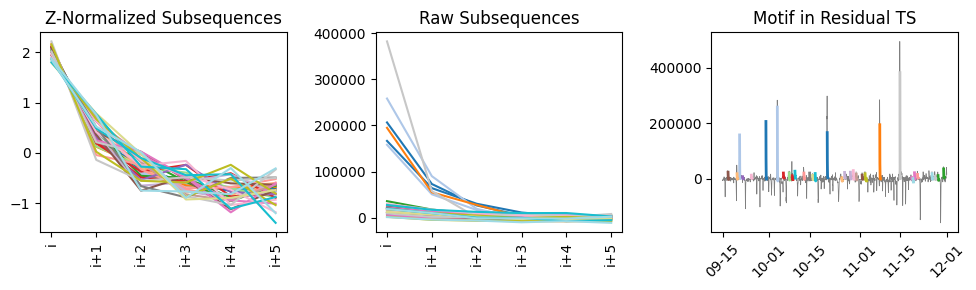

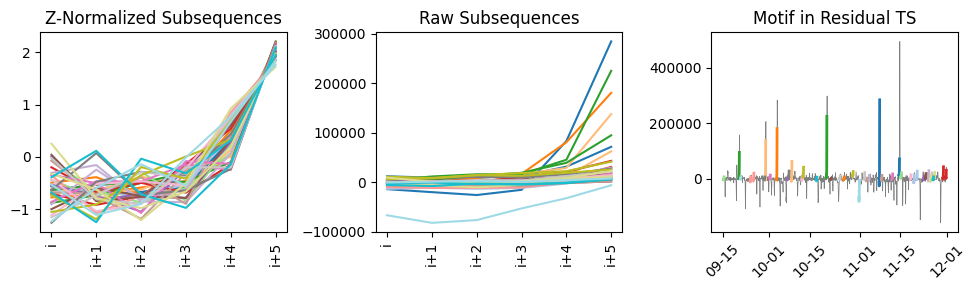

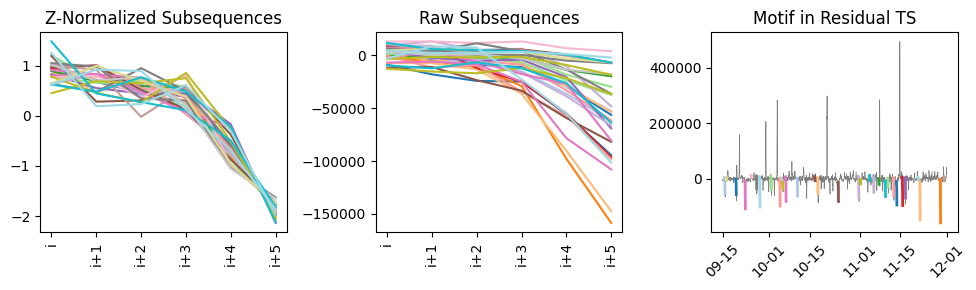

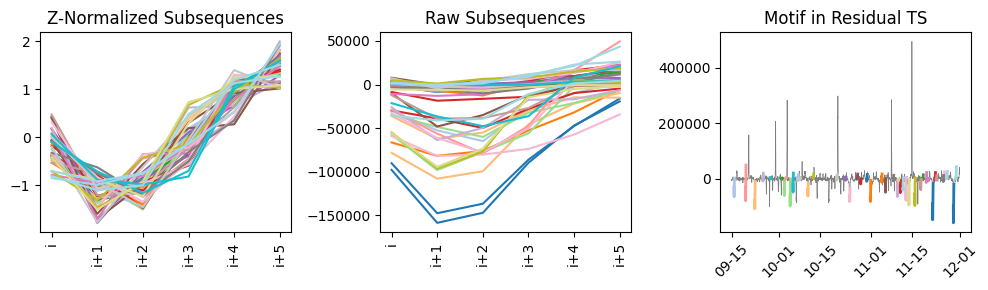

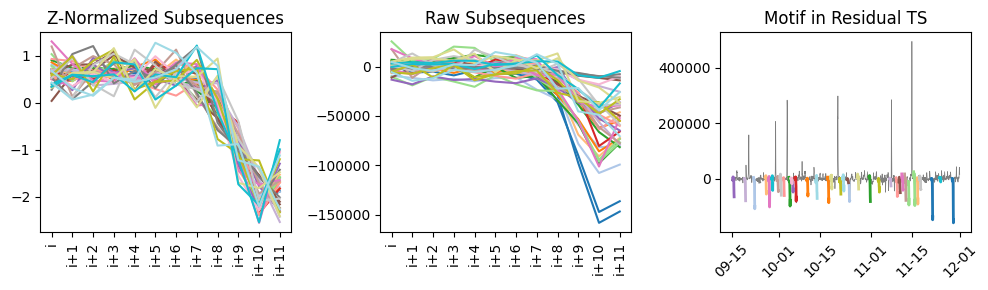

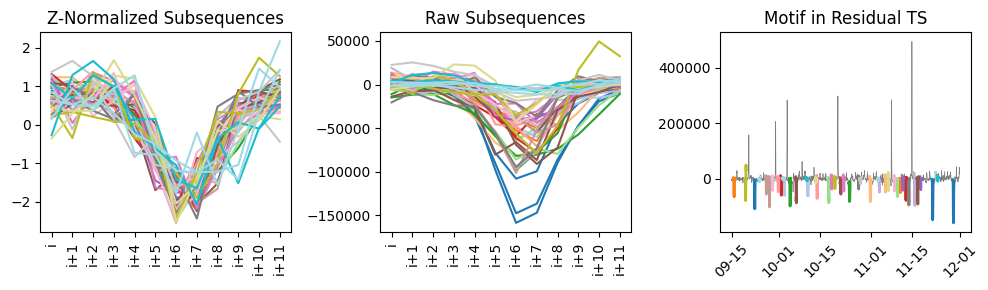

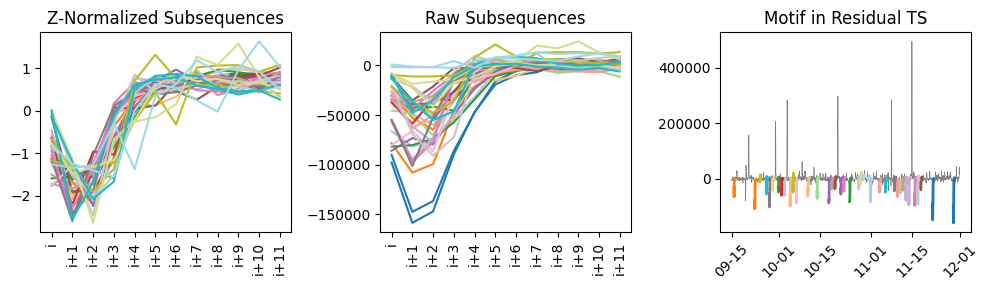

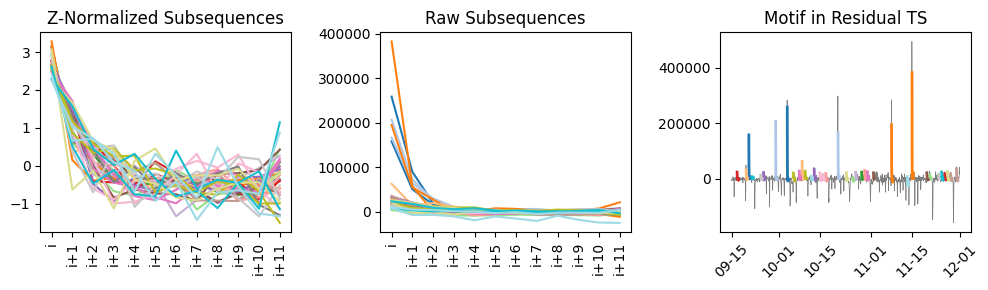

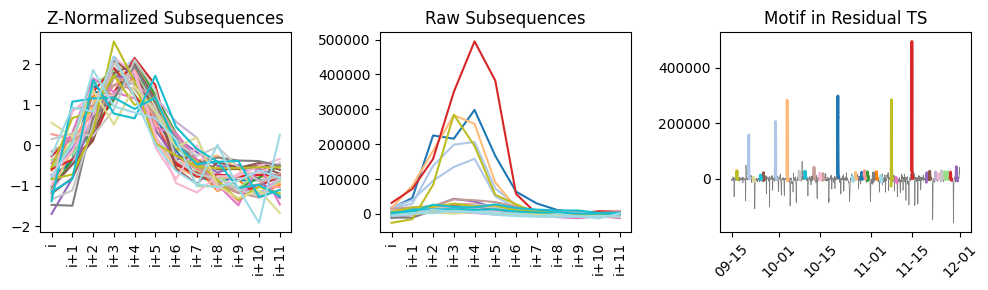

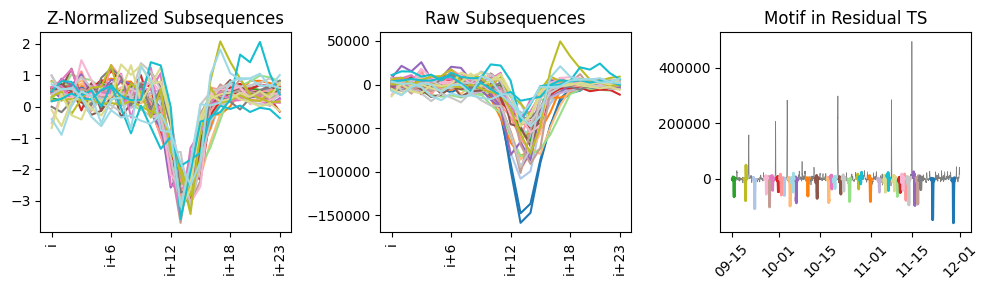

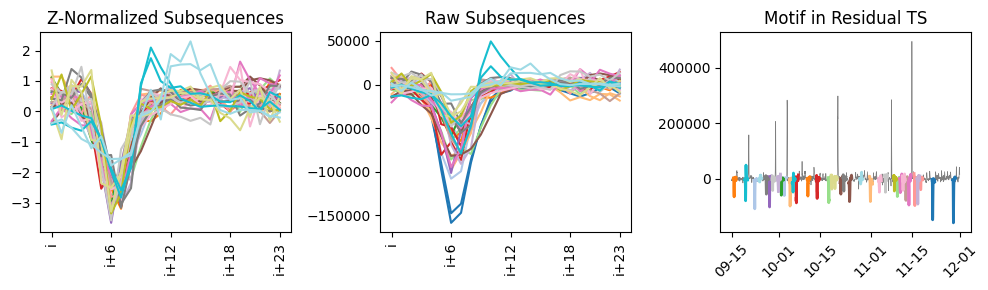

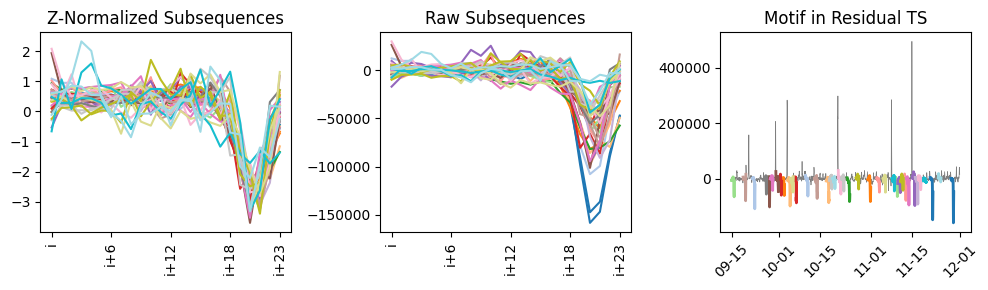

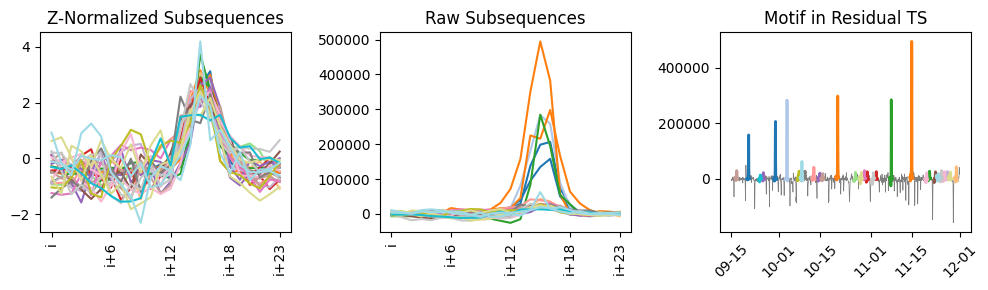

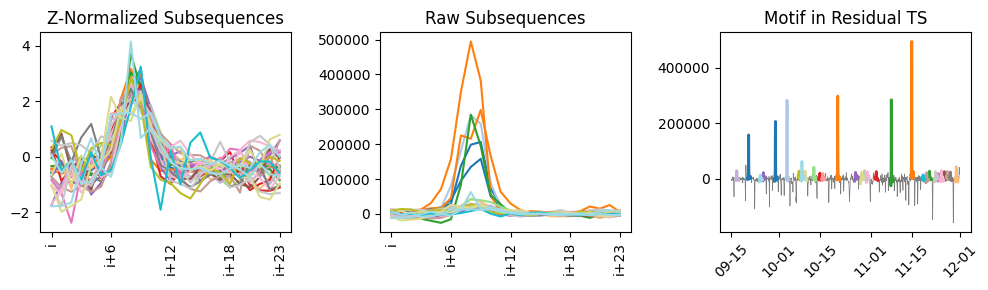

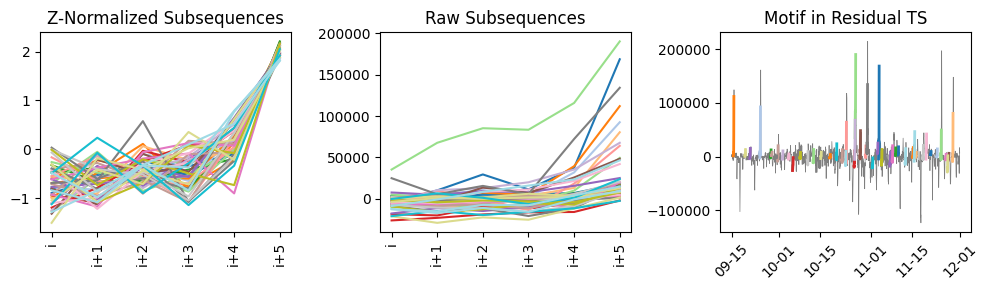

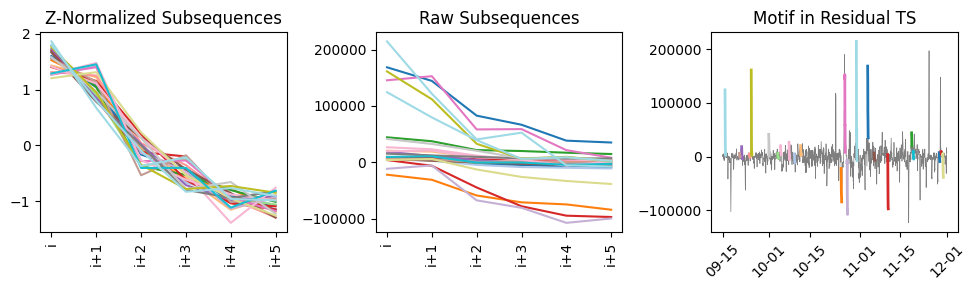

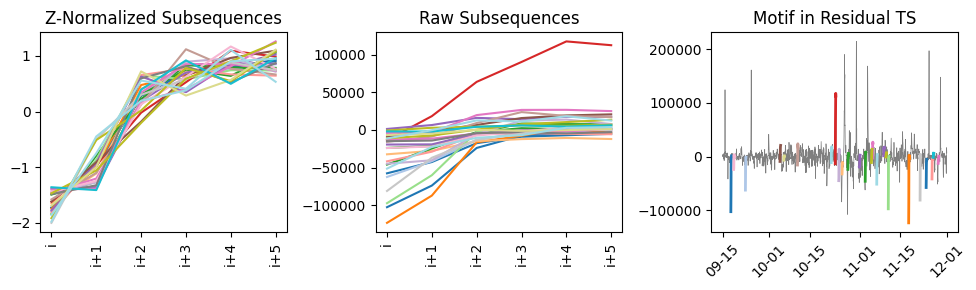

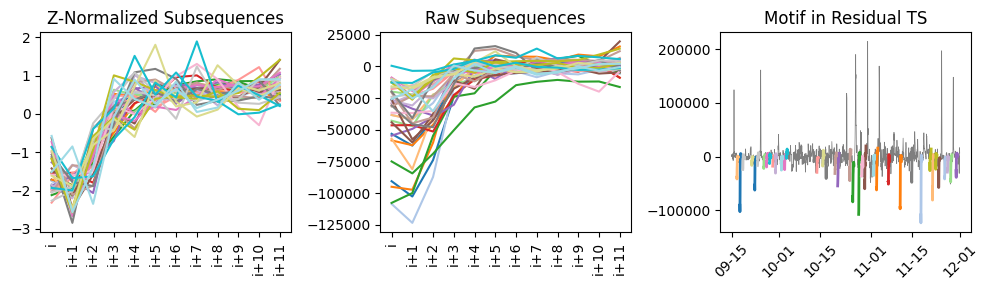

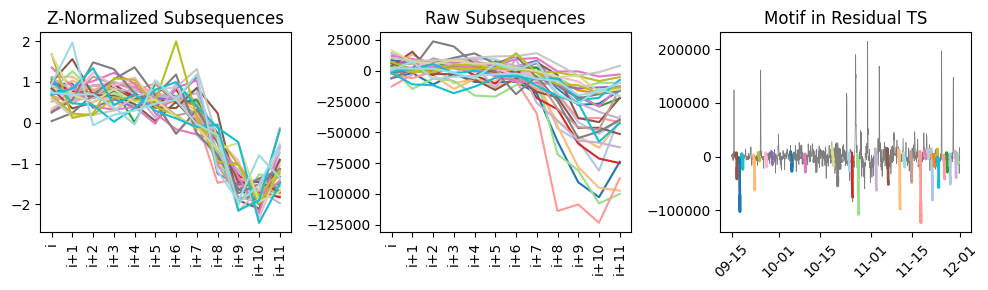

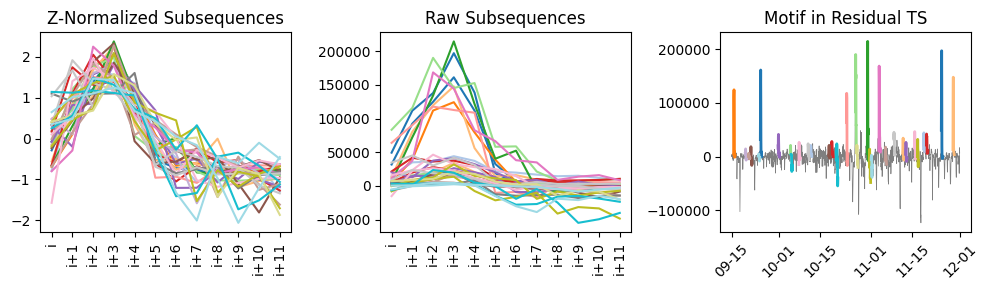

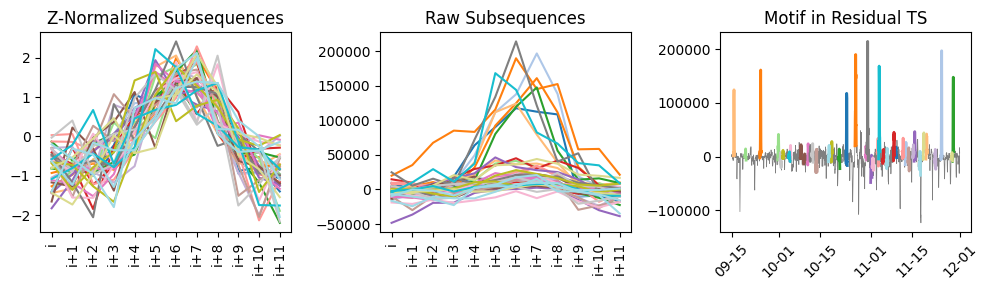

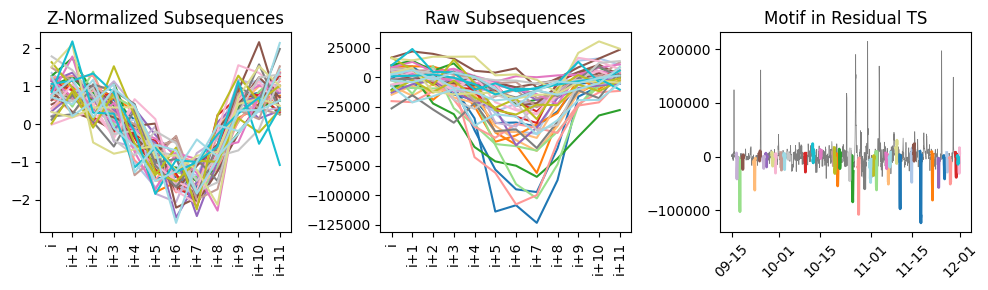

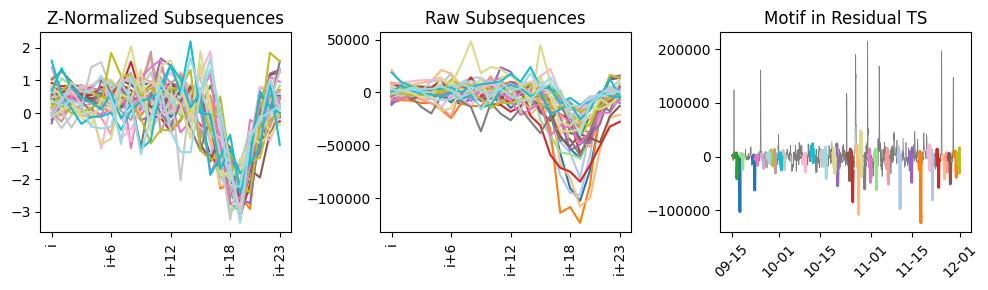

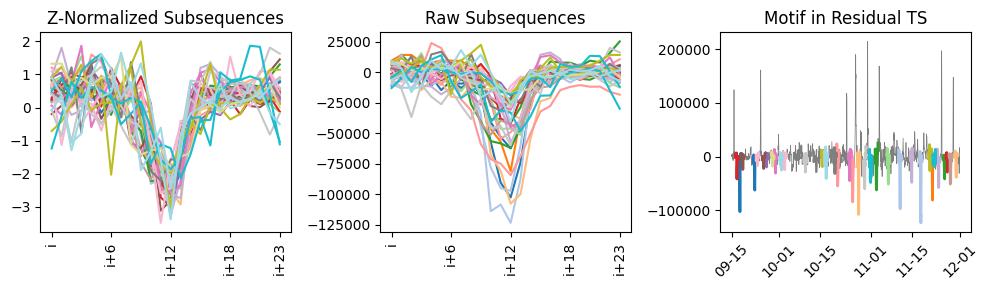

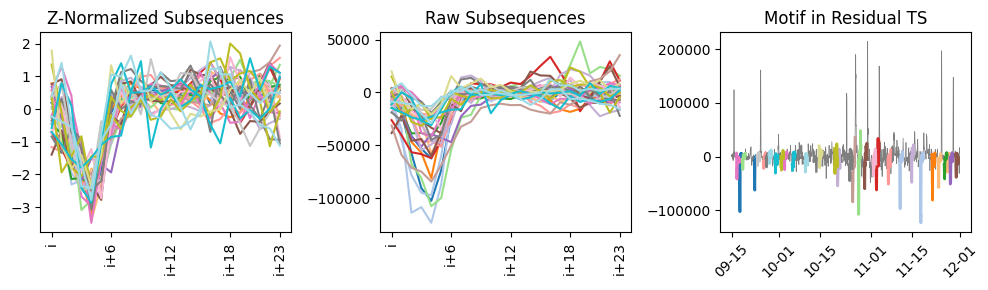

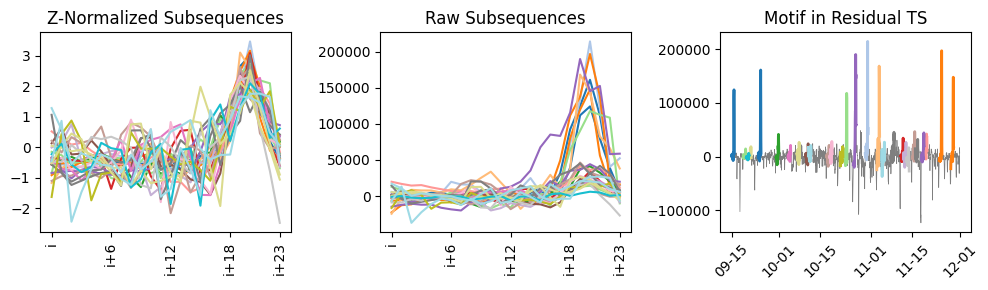

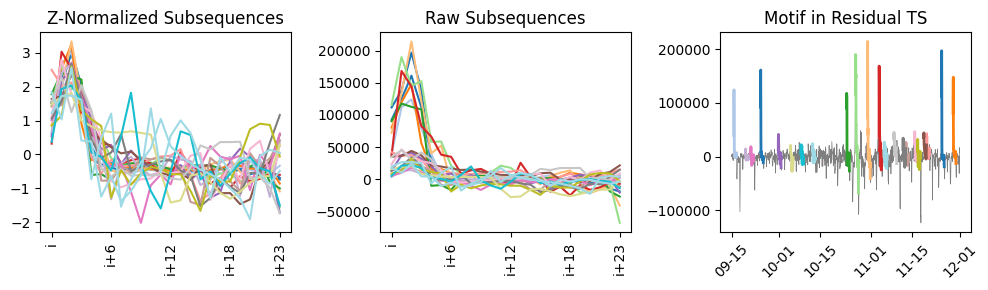

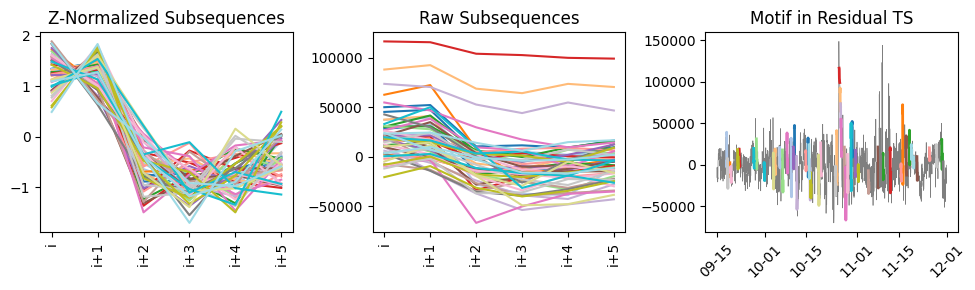

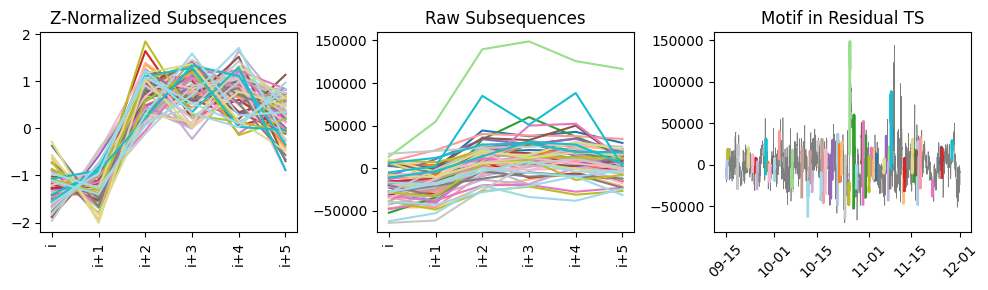

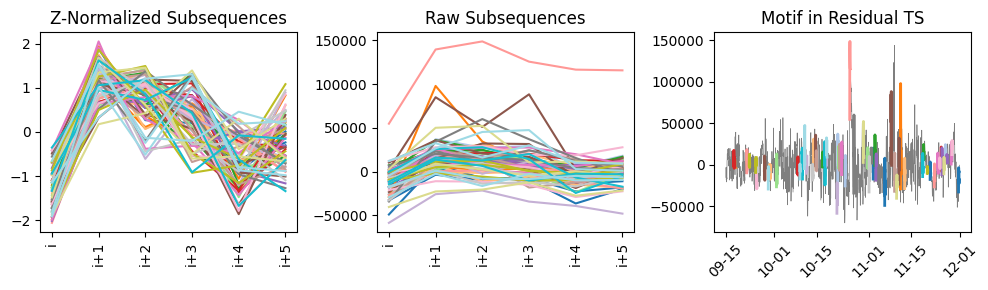

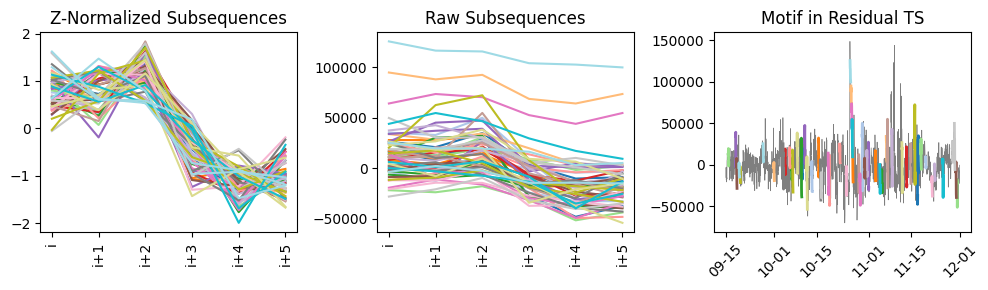

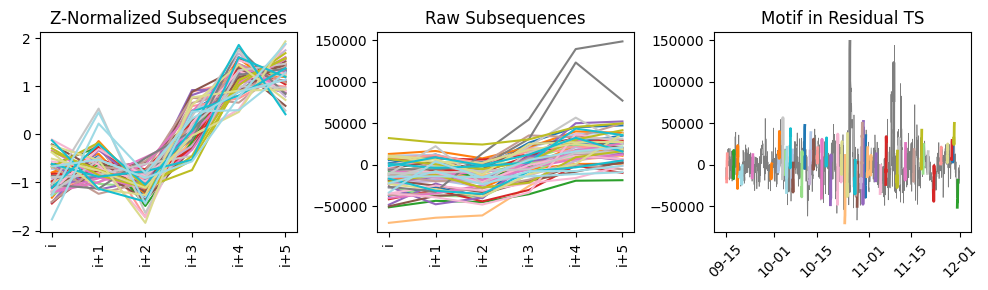

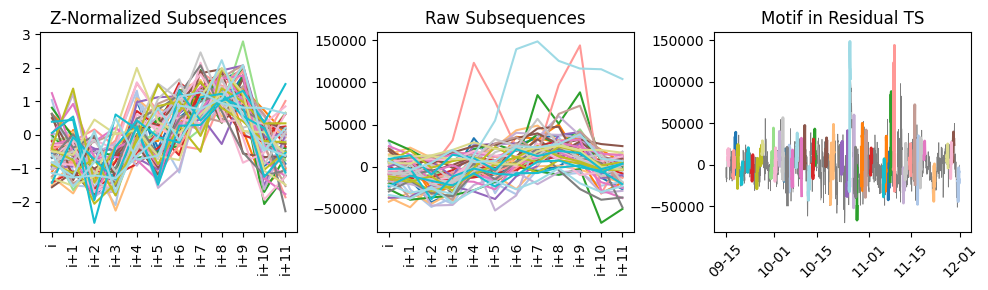

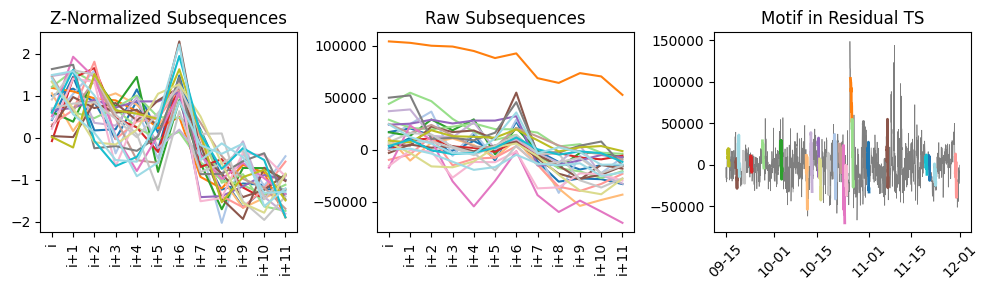

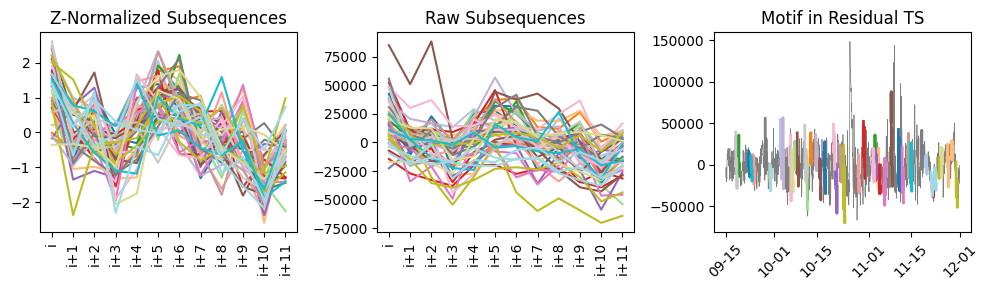

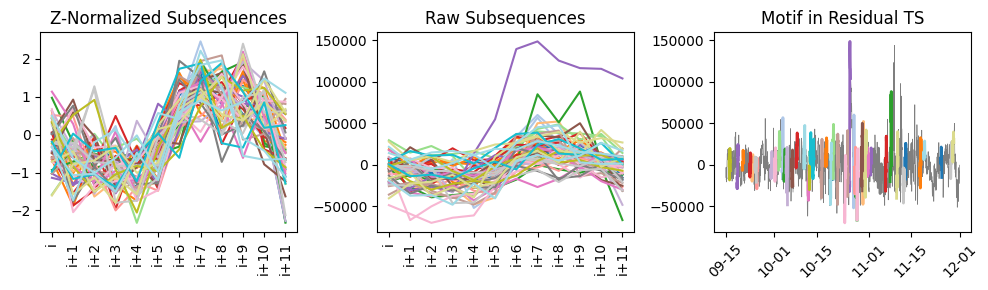

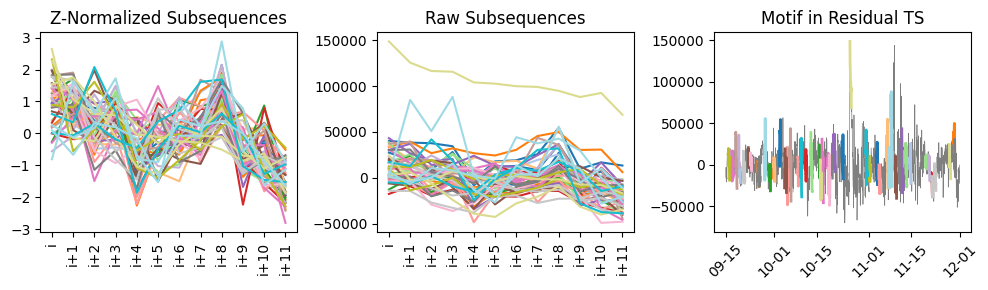

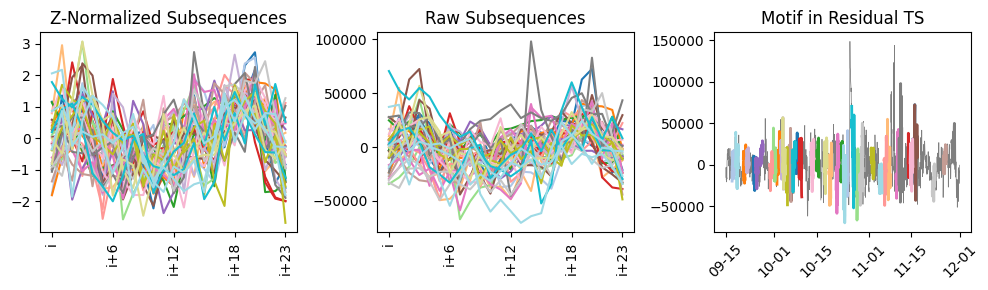

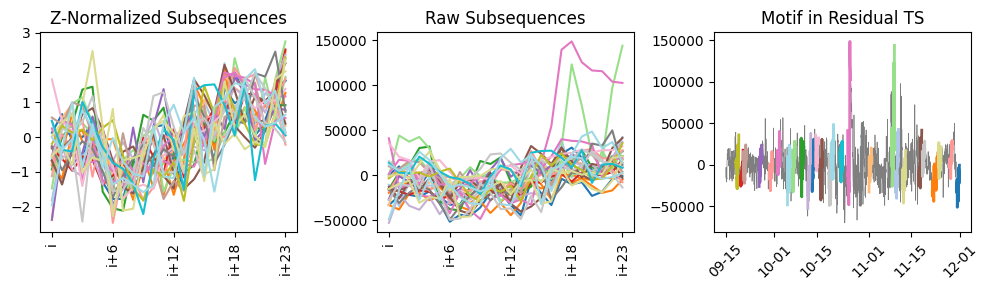

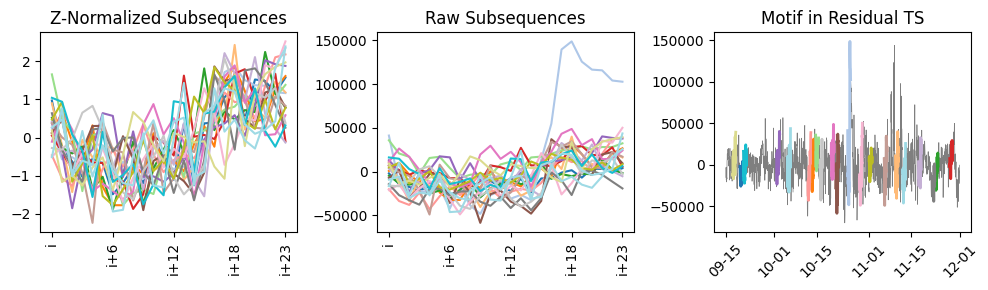

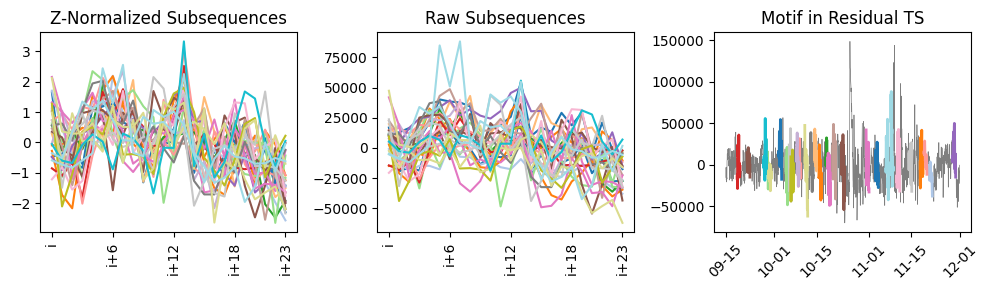

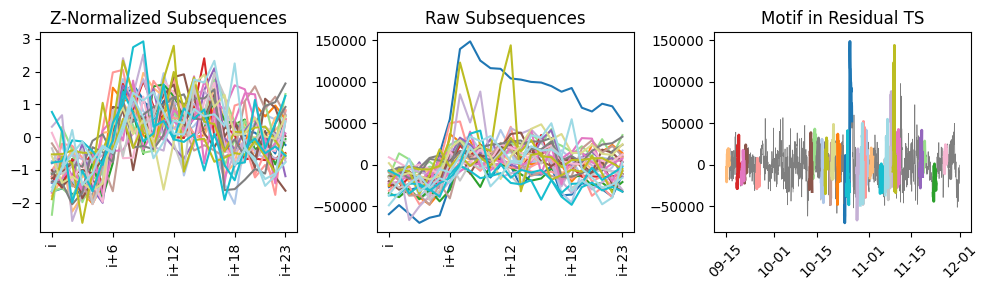

In [16]:
# plot top motif
for i, df in top_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]
        )
    )
    mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    save_path = results_path + "/" + taz_id_name[i[0]]
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    subsequence_lengths = mp_stats_table["m"].unique()
    ts = pd.DataFrame(df["residuals"].values, index=df["index"])
    ts.index = pd.to_datetime(ts.index)
    for m in subsequence_lengths:
        print("Motif length: ", m)
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        for top_motif in top_motifs.to_dict(orient="records"):
            m = top_motif["m"]
            dimensions = [top_motif["Features"]]
            features = sorted([int(dimension) for dimension in dimensions])
            indices = top_motif["Indices"].replace("[", "").replace("]", "").split(",")
            indices = [int(i) for i in indices]
            motif_name = str(i[0]) + "_" + str(i[1]) + "_" + str(top_motif["ID"])
            plot_motif([ts], features, m, indices, motif_name, save_path)

# Daily TAZ granularity

In [17]:
# read csv
daily_data = pd.read_csv(
    "../data/populationdensity/daily_taz.csv",
    parse_dates=["one_time"],
    date_format="%Y-%m-%d",
    index_col=0,
)
# taz_id to taz_name dict
taz_id_name = {}
for taz_id in daily_data["taz_id"].unique():
    taz_name = daily_data[daily_data["taz_id"] == taz_id]["taz_name"].values[0]
    taz_id_name[taz_id] = taz_name

daily_data = daily_data[daily_data["taz_name"] != "Beato (Picheleira)"]
daily_data = daily_data[daily_data["taz_name"] != "Alcântara (Ribeirinha - Belém)"]
daily_data

taz_id                                 taz_name   one_time  \
0          1               Belém (Ribeirinha - Belém) 2021-11-30   
1         74                Santa Maria Maior (Baixa) 2021-11-30   
2         11                    Ajuda (Ajuda | Oeste) 2021-11-30   
3          2                       Belém (Alto Duque) 2021-11-30   
4          8            Alcântara (Santo Amaro | Sul) 2021-11-30   
...      ...                                      ...        ...   
7296      52          Alvalade (Cidade Universitária) 2021-09-15   
7297     103          Parque das Nações (Parque Tejo) 2021-09-15   
7298      45                     Lumiar (Paço Lumiar) 2021-09-15   
7299      99  Parque das Nações (Parque Nações | Sul) 2021-09-15   
7300      11                    Ajuda (Ajuda | Oeste) 2021-09-15   

      sum_terminals  sum_roaming_terminals  sum_terminals_with_active_data  \
0          451966.0                28595.0                        433297.0   
1         3496997.0               448048.0                       3373682.0   
2          187456.0                 2968.0                        181110.0   
3         2003644.0                18880.0                       1934676.0   
4         1337005.0                37381.0                       1255329.0   
...             ...                    ...                             ...   
7296      1237723.0                25486.0                       1187636.0   
7297      1938115.0                21627.0                       1895478.0   
7298      1584729.0                15612.0                       1538089.0   
7299      2613386.0                91066.0                       2529048.0   
7300       161414.0                 2231.0                        156600.0   

      sum_roaming_terminals_with_active_data  sum_phonecalls  \
0                                    28420.0         16088.0   
1                                   443026.0        101232.0   
2                                     2946.0          4871.0   
3                                    18754.0         52044.0   
4                                    36914.0         68161.0   
...                                      ...             ...   
7296                                 25210.0         34455.0   
7297                                 21504.0         34304.0   
7298                                 15500.0         34419.0   
7299                                 89838.0         67951.0   
7300                                  2208.0          3514.0   

      sum_ended_phonecalls  avg_upstream_bandwidth  avg_downstream_bandwidth  \
0                   3305.0             4853.284429              34185.103587   
1                  26173.0            28874.841672              60980.068857   
2                   1638.0             8833.336655              38008.021073   
3                  24849.0             7428.568222              36438.320410   
4                  11017.0             7111.558636              67180.857398   
...                    ...                     ...                       ...   
7296               18926.0             8520.790422              42818.712867   
7297               20690.0             6586.064210              37306.461881   
7298               14609.0             5239.633259              35236.084394   
7299               30540.0             8825.827646              74494.504453   
7300                1830.0            17827.998637              67196.111025   

      max_upstream_bandwidth  max_downstream_bandwidth  sum_terminals_sharing  \
0                 56530416.0              4.827092e+08           0.000000e+00   
1                716870016.0              9.756566e+08           1.617781e-32   
2                 56506204.0              1.839415e+08           0.000000e+00   
3                174233056.0              9.665061e+08           3.652603e-12   
4                129730224.0              1.080369e+09           4.030063e-10   
...                      ...        

In [18]:
features = ["sum_terminals"]
stats_table = pd.DataFrame()
daily_resids = {}
# for each taz_id
for taz_id in daily_data["taz_id"].unique():
    # get the data for that taz_id
    taz_data = daily_data[daily_data["taz_id"] == taz_id]
    taz_data = taz_data.drop(columns=["taz_name"])
    taz_data["datetime"] = pd.to_datetime(taz_data["one_time"])
    taz_data = taz_data.drop(columns=["one_time", "taz_id", "wkt_taz"])
    taz_data.set_index("datetime", inplace=True)
    for data_feature in features:
        time_serie = taz_data[[data_feature]].asfreq("d")
        if np.all(time_serie == 0):
            continue
        period = 7
        res = STL(np.squeeze(time_serie), period=period).fit()
        daily_resids[str(taz_id) + "_" + data_feature] = res.resid

        var_resid = np.var(res.resid)
        var_observed = np.var(res.observed)
        trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
        noise_strength = var_resid / var_observed

        seasonal_individial_strengths = {}
        seasonal_individial_strengths["F_" + str(period)] = max(
            0, 1 - (var_resid / np.var(res.seasonal + res.resid))
        )
        seasonal_strength = max(0, 1 - (var_resid / np.var(res.seasonal + res.resid)))

        stats_df = {
            "id": taz_id,
            "Feature": data_feature,
            "F_T": round(trend_strength, 3),
            "F_S": round(seasonal_strength, 3),
            "F_R": round(noise_strength, 3),
        }

        stats_df["F_S"] = round(seasonal_individial_strengths["F_" + str(period)], 3)

        stats_table = pd.concat(
            [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
        )

stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
# save the table
results_path = "../results/populationdensity/daily_taz"
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")
    os.makedirs(results_path + "/mp_indices")
stats_table.to_csv(results_path + "/daily_taz_decomposition_summary.csv", index=False)
# get the name from the taz id
stats_table["Name"] = stats_table["id"].apply(lambda x: taz_id_name[x])
stats_table

id        Feature    F_T    F_S    F_R  \
77  37  sum_terminals  0.273  0.418  0.479   
93  89  sum_terminals  0.365  0.475  0.403   
59  38  sum_terminals  0.511  0.304  0.402   
44  41  sum_terminals  0.268  0.535  0.392   
0    1  sum_terminals  0.545  0.287  0.386   
..  ..            ...    ...    ...    ...   
87  46  sum_terminals  0.934  0.684  0.062   
69  78  sum_terminals  0.942  0.463  0.055   
39  81  sum_terminals  0.946  0.508  0.050   
61  29  sum_terminals  0.950  0.599  0.048   
57  30  sum_terminals  0.965  0.376  0.035   

                                             Name  
77  São Domingos de Benfica (Estrada Luz | Oeste)  
93                             Lumiar (Aeroporto)  
59                       Carnide (Avenidas Novas)  
44                      Lumiar (Telheiras | Este)  
0                      Belém (Ribeirinha - Belém)  
..                                            ...  
87                     Lumiar (Telheiras | Norte)  
69                     Penha de França (São João)  
39                       Beato (Madre Deus | Sul)  
61    São Domingos de Benfica (Sete Rios | Norte)  
57   São Domingos de Benfica (Estrada Luz | Este)  

[101 rows x 6 columns]

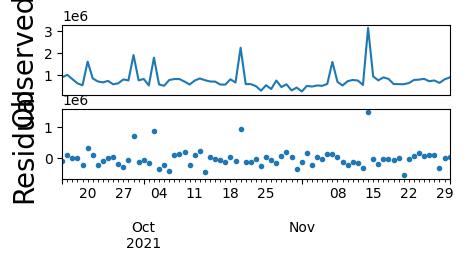

In [19]:
# plot the data and residuals of top 3 taz_ids
top_daily_taz_ids = stats_table["id"].head(1).values
# create dataframe with taz_id and resids
top_daily_resids = pd.DataFrame()
for taz_id in top_daily_taz_ids:
    for data_feature in features:
        # add to dataframe, id, data feature and daoly
        observed = (
            daily_data[daily_data["taz_id"] == taz_id][[data_feature, "one_time"]]
            .sort_values(by="one_time")
            .set_index("one_time")
        )
        index = observed.index.values
        row = {
            "id": taz_id,
            "feature": data_feature,
            "index": index,
            "observed": observed.T.values[0],
            "residuals": daily_resids[str(taz_id) + "_" + data_feature],
        }
        top_daily_resids = pd.concat(
            [top_daily_resids, pd.DataFrame(row)], ignore_index=True
        )


# for (id, feature) get dataframe and plot observed and residuals
for i, df in top_daily_resids.groupby(by=["id", "feature"]):
    # plot observed and residuals
    fig, axes = plt.subplots(figsize=(5, 2), ncols=1, nrows=2, sharex=True)
    observed = pd.DataFrame(df["observed"].values, index=df["index"])
    resid = pd.DataFrame(df["residuals"].values, index=df["index"])
    observed.plot(ax=axes[0], legend=False, label="", xlabel="", ylabel="Observed")
    resid.plot(ax=axes[1], style=".", legend=False, xlabel="", ylabel="Residual")
    axes[0].axes.get_xaxis().set_visible(False)
    plt.show()

In [20]:
# motif discovery
import stumpy

# discover motifs
normalize = True
subsequence_lengths = [5]

for m in subsequence_lengths:
    for i, df in top_daily_resids.groupby(by=["id", "feature"]):
        X = np.squeeze(df["residuals"].values)
        out = stumpy.stump(X, m, normalize=normalize)
        np.save(
            results_path
            + "/mp/daily_taz_normalized={}_m={}_{}_{}.npy".format(
                normalize, m, i[0], i[1]
            ),
            out,
            allow_pickle=True,
        )

In [21]:
k = None
min_neighbors = 1
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
for i, df in top_daily_resids.groupby(by=["id", "feature"]):
    print(i[0], taz_id_name[i[0]])
    mp_stats_table = pd.DataFrame()
    for m in subsequence_lengths:
        X = np.squeeze(df["residuals"].values)
        mp = np.load(
            results_path
            + "/mp/daily_taz_normalized={}_m={}_{}_{}.npy".format(
                normalize, m, i[0], i[1]
            ),
            allow_pickle=True,
        )
        motif_distances, motif_indices = stumpy.motifs(
            X,
            mp[:, 0],
            max_distance=max_distance,
            max_matches=max_matches,
            cutoff=cutoff,
            min_neighbors=min_neighbors,
            max_motifs=max_motifs,
            normalize=normalize,
        )
        if len(motif_indices[0]) == 0:
            continue
        print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
        # to work with table_summary_motifs which expects multidimensional motifs
        motif_subspaces = [np.array([0])] * len(motif_indices)
        X = np.array([X])
        table = table_summary_motifs(
            motif_indices,
            motif_distances,
            motif_subspaces,
            X,
            m,
            normalize,
            max_distance,
        )
        print("Sig ", np.sum(table["p-value"] < 0.001))
        # hochberg procedure
        p_values = table["p-value"].to_numpy()
        critical_value = NullModel.hochberg_critical_value(p_values, 0.05)
        sig = (
            table["p-value"] < critical_value
            if critical_value != 0
            else table["p-value"] <= critical_value
        )
        table["Sig_Hochber"] = sig

        print(
            "Sig after Hochberg: {}, critical value: {}".format(
                np.sum(sig), critical_value
            )
        )
        mp_stats_table = (
            table
            if mp_stats_table.empty
            else pd.concat([mp_stats_table, table], ignore_index=True)
        )
    mp_stats_table.to_csv(
        results_path
        + "/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]
        ),
        index=False,
    )

37 São Domingos de Benfica (Estrada Luz | Oeste)
m:5, #Motifs:9
Sig  0
Sig after Hochberg: 0, critical value: 0.0041439395403237884


In [22]:
# get top 3 most significant for each motif length
for i, df in top_daily_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]
        )
    )
    # excluded p-value > 0.001
    # mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    subsequence_lengths = mp_stats_table["m"].unique()
    for m in subsequence_lengths:
        print("########## m:{} #########".format(m))
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        top_motifs = top_motifs[
            [
                "ID",
                "#Matches",
                "CE",
                "Score Unified",
                "max(dists)",
                "min(dists)",
                "med(dists)",
                "p-value",
                "Explained Var(%)",
            ]
        ]
        top_motifs["p-value"] = top_motifs["p-value"].apply(lambda x: f"{x:.2e}")
        print(top_motifs.to_latex(index=False, float_format="%.3f"))
        print("\n")

########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
########## m:5 #########
\begin{tabular}{rrrrrrrlr}
\toprule
ID & #Matches & CE & Score Unified & max(dists) & min(dists) & med(dists) & p-value & Explained Var(%) \\
\midrule
0 & 4 & 0.652 & 0.556 & 1.008 & 0.140 & 0.503 & 4.14e-03 & 49.190 \\
5 & 1 & 0.715 & 0.524 & 0.614 & 0.614 & 0.614 & 1.00e+00 & 7.630 \\
4 & 1 & 0.626 & 0.506 & 0.518 & 0.518 & 0.518 & 9.60e-01 & 10.170 \\
1 & 2 & 0.587 & 0.496 & 0.936 & 0.283 & 0.610 & 9.97e-01 & 15.690 \\
2 & 2 & 0.486 & 0.465 & 0.831 & 0.344 & 0.588 & 3.65e-02 & 34.500 \\
\bottomrule
\end{tabular}





########## taz_name:São Domingos de Benfica (Estrada Luz | Oeste) #########
Motif length:  5


/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/miguel/miniconda3/envs/motifsinresidualenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over bo

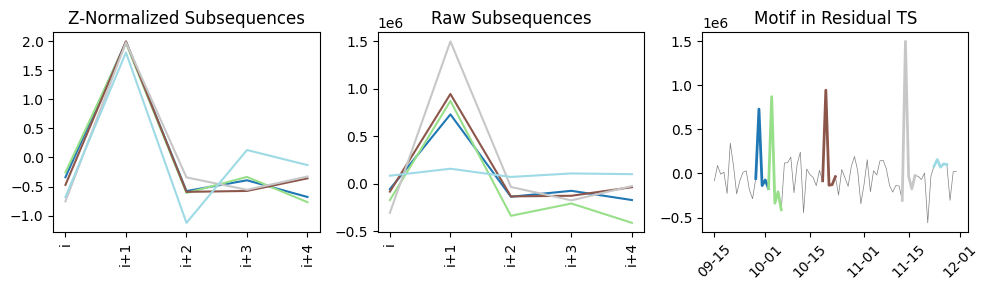

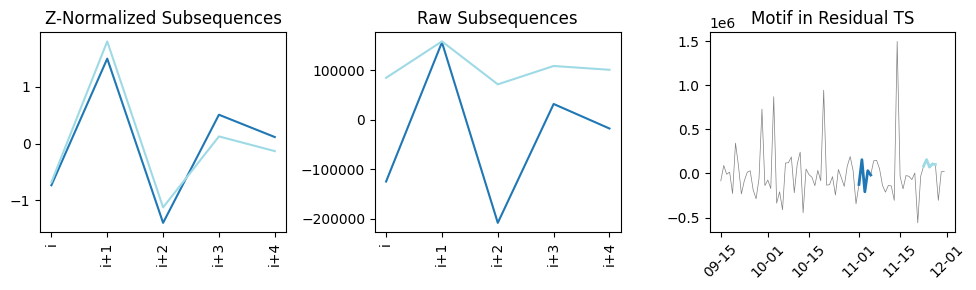

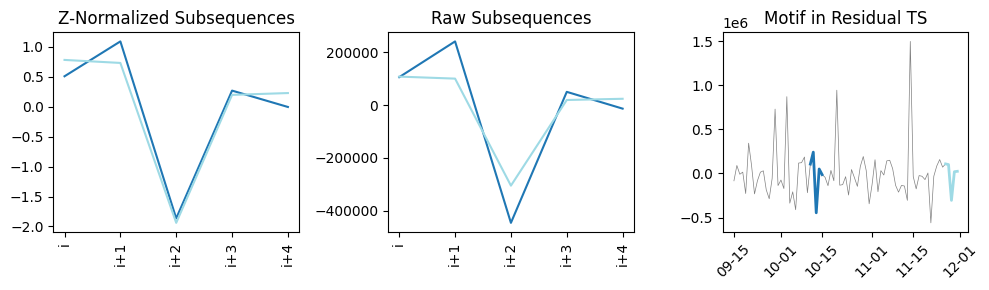

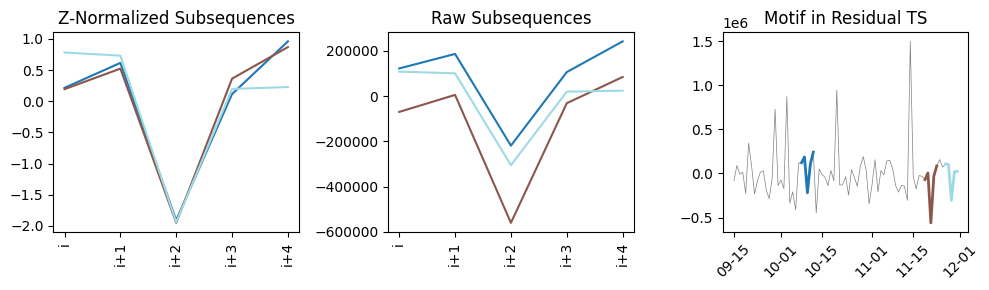

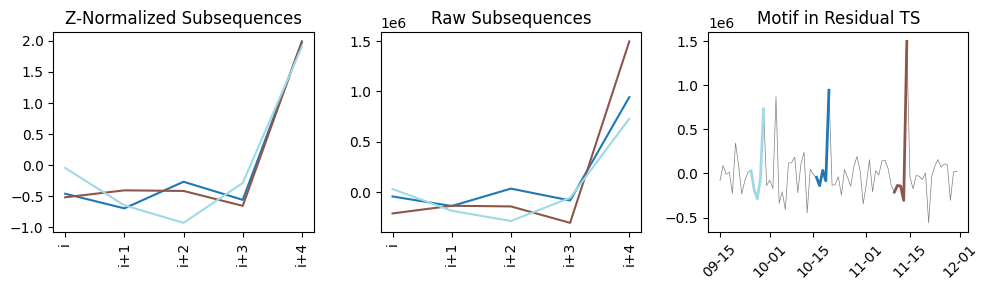

In [23]:
# plot top motif
for i, df in top_daily_resids.groupby(by=["id", "feature"]):
    print("########## taz_name:{} #########".format(taz_id_name[i[0]]))
    mp_stats_table = pd.read_csv(
        results_path
        + "/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}_{}.csv".format(
            min_neighbors, max_distance, cutoff, max_matches, max_motifs, i[0]
        )
    )
    # mp_stats_table = mp_stats_table[mp_stats_table["p-value"] < 0.001]
    save_path = results_path + "/" + taz_id_name[i[0]]
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    subsequence_lengths = mp_stats_table["m"].unique()
    ts = pd.DataFrame(df["residuals"].values, index=df["index"])
    ts.index = pd.to_datetime(ts.index)
    for m in subsequence_lengths:
        print("Motif length: ", m)
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="Score Unified", ascending=False).head(5)
        for top_motif in top_motifs.to_dict(orient="records"):
            m = top_motif["m"]
            dimensions = [top_motif["Features"]]
            features = sorted([int(dimension) for dimension in dimensions])
            indices = top_motif["Indices"].replace("[", "").replace("]", "").split(",")
            indices = [int(i) for i in indices]
            motif_name = str(i[0]) + "_" + str(i[1]) + "_" + str(top_motif["ID"])
            plot_motif([ts], features, m, indices, motif_name, save_path)

# Hourly Township Granularity

In [40]:
hourly_township_data = pd.read_csv(
    "../data/populationdensity/hourly_township.csv",
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)
hourly_township_data

dicofre_code    township_name            one_time  sum_terminals  \
0            110663  Penha de França 2021-11-29 13:00:00       158355.0   
1            110660          Estrela 2021-11-29 13:00:00       126795.0   
2            110661     Misericórdia 2021-11-29 13:00:00       130089.0   
3            110610        Campolide 2021-11-29 13:00:00       141620.0   
4            110654         Alvalade 2021-11-29 13:00:00       552447.0   
...             ...              ...                 ...            ...   
40746        110654         Alvalade 2021-11-29 14:00:00       460286.0   
40747        110666    Santo António 2021-11-29 14:00:00       296090.0   
40748        110667      São Vicente 2021-11-29 14:00:00        69901.0   
40749        110610        Campolide 2021-11-29 14:00:00       134983.0   
40750        110663  Penha de França 2021-11-29 14:00:00       137929.0   

       sum_roaming_terminals  sum_terminals_with_active_data  \
0                     3274.0                        150382.0   
1                     5971.0                        119324.0   
2                    11769.0                        123826.0   
3                     2863.0                        131858.0   
4                     8924.0                        522013.0   
...                      ...                             ...   
40746                 8052.0                        443238.0   
40747                11756.0                        288802.0   
40748                 5407.0                         67756.0   
40749                 2444.0                        129015.0   
40750                 3014.0                        134127.0   

       sum_roaming_terminals_with_active_data  sum_phonecalls  \
0                                      3208.0          5579.0   
1                                      5903.0          6419.0   
2                                     11580.0          5293.0   
3                                      2824.0          6629.0   
4                                      8800.0         22186.0   
...                                       ...             ...   
40746                                  8034.0         12605.0   
40747                                 11736.0          5591.0   
40748                                  5393.0          2004.0   
40749                                  2439.0          4377.0   
40750                                  3012.0          3181.0   

       sum_ended_phonecalls  avg_upstream_bandwidth  avg_downstream_bandwidth  \
0                    1838.0            16385.683844             146081.324196   
1                    1155.0            16553.045512              91474.076898   
2                    1368.0            48063.316006              47523.270522   
3                    1506.0             4798.054128              34495.467216   
4                    6200.0            12529.229719              56706.753777   
...                     ...                     ...                       ...   
40746                4521.0             9091.858610              39757.561417   
40747                2486.0            10325.166282              43269.994155   
40748                 547.0            17296.799463              71299.526772   
40749                 926.0            13247.972653              42930.901504   
40750                1341.0            17155.346361             459495.812695   

       min_avg_downstream_bandwidth  min_avg_upstream_bandwidth  \
0                          0.000000                    0.000000   
1                          0.000000                    0.000000   
2                         74.750000                    2.980000   
3                          0.000000                    0.000000   
4                          0.000000                    0.000000   
...                             ...                         ...   
40746                      0.000000                    0.000000   
40747                   1346.574966            

In [42]:
# TODO: check warning
features = ["sum_terminals"]
stats_table = pd.DataFrame()
township_resids = {}

for township_name in hourly_township_data["township_name"].unique():
    township_data = hourly_township_data[
        hourly_township_data["township_name"] == township_name
    ]
    township_data["datetime"] = pd.to_datetime(township_data["one_time"])
    township_data = township_data.drop(
        columns=["one_time", "township_name", "wkt_township"]
    )
    township_data.set_index("datetime", inplace=True)
    for data_feature in features:
        time_serie = taz_data[[data_feature]].asfreq("d")
        if np.all(time_serie == 0):
            continue
        period = 7
        res = STL(np.squeeze(time_serie), period=period).fit()
        daily_resids[str(taz_id) + "_" + data_feature] = res.resid

        var_resid = np.var(res.resid)
        var_observed = np.var(res.observed)
        trend_strength = max(0, 1 - (var_resid / np.var(res.trend + res.resid)))
        noise_strength = var_resid / var_observed

        seasonal_individial_strengths = {}
        seasonal_individial_strengths["F_" + str(period)] = max(
            0, 1 - (var_resid / np.var(res.seasonal + res.resid))
        )
        seasonal_strength = max(0, 1 - (var_resid / np.var(res.seasonal + res.resid)))

        stats_df = {
            "id": township_name,
            "Feature": data_feature,
            "F_T": round(trend_strength, 3),
            "F_S": round(seasonal_strength, 3),
            "F_R": round(noise_strength, 3),
        }

        stats_df["F_S"] = round(seasonal_individial_strengths["F_" + str(period)], 3)

        stats_table = pd.concat(
            [stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True
        )

stats_table = stats_table.sort_values(by=["F_R"], ascending=False)
# save the table
results_path = "../results/populationdensity/hourly_township"
# create folders in results path
if not os.path.exists(results_path):
    os.makedirs(results_path + "/mp")
    os.makedirs(results_path + "/mp_indices")
stats_table.to_csv(
    results_path + "/hourly_township_decomposition_summary.csv", index=False
)
stats_table

/tmp/ipykernel_25767/1119255898.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  township_data["datetime"] = pd.to_datetime(township_data["one_time"])
/tmp/ipykernel_25767/1119255898.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  township_data["datetime"] = pd.to_datetime(township_data["one_time"])
/tmp/ipykernel_25767/1119255898.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

id        Feature    F_T    F_S    F_R
0           Penha de França  sum_terminals  0.674  0.664  0.207
1                   Estrela  sum_terminals  0.674  0.664  0.207
22              Santa Clara  sum_terminals  0.674  0.664  0.207
21        Parque das Nações  sum_terminals  0.674  0.664  0.207
20                   Lumiar  sum_terminals  0.674  0.664  0.207
19                  Carnide  sum_terminals  0.674  0.664  0.207
18            Santo António  sum_terminals  0.674  0.664  0.207
17              São Vicente  sum_terminals  0.674  0.664  0.207
16                  Benfica  sum_terminals  0.674  0.664  0.207
15                Alcântara  sum_terminals  0.674  0.664  0.207
14                  Marvila  sum_terminals  0.674  0.664  0.207
13                    Beato  sum_terminals  0.674  0.664  0.207
12                    Ajuda  sum_terminals  0.674  0.664  0.207
11                  Areeiro  sum_terminals  0.674  0.664  0.207
10           Avenidas Novas  sum_terminals  0.674  0.664  0.207
9                     Belém  sum_terminals  0.674  0.664  0.207
8          Campo de Ourique  sum_terminals  0.674  0.664  0.207
7         Santa Maria Maior  sum_terminals  0.674  0.664  0.207
6   São Domingos de Benfica  sum_terminals  0.674  0.664  0.207
5                   Arroios  sum_terminals  0.674  0.664  0.207
4                  Alvalade  sum_terminals  0.674  0.664  0.207
3                 Campolide  sum_terminals  0.674  0.664  0.207
2              Misericórdia  sum_terminals  0.674  0.664  0.207
23                  Olivais  sum_terminals  0.674  0.664  0.207